# rcnn的局限性

RCNN的首要问题在于：

    * 目标产生了形变
    * 目标框要一一识别
    
    
* 目标框一一识别

2000个目标框，每个都需要调用CNN进行识别。这是算力上的严重浪费。

如果能对整张图像进行特征提取，然后再对其对应的特征进一步的分类，就可以解决上述问题。

* 目标产生形变

从selective search中产生的目标框，想要从其中获取特征，需要先把他resize成相同大小的图像。

这样就会造成较大的误差，严重降低了识别精度。


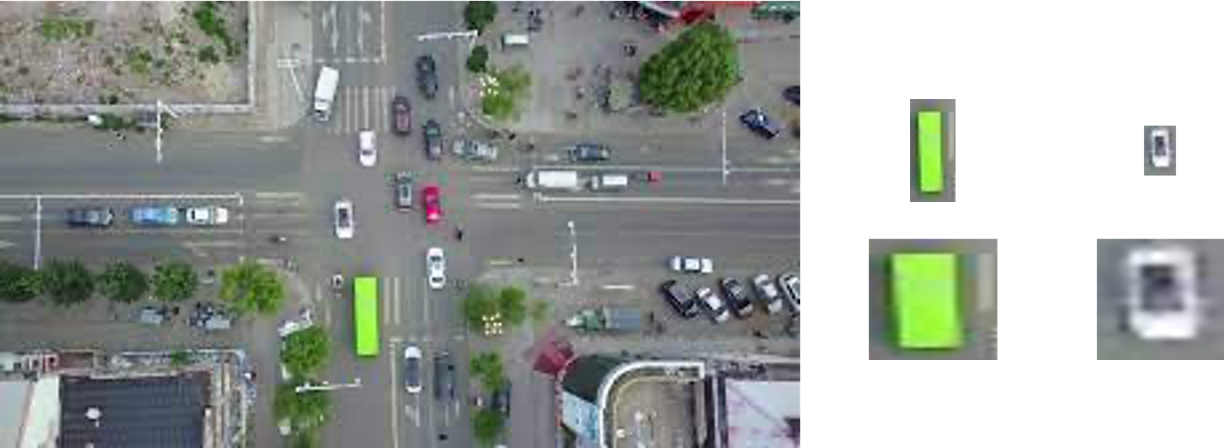

**为什么要变成相同大小的内容？**

**因为CNN需要变成相同大小的内容。**

为什么CNN需要输入相同大小的内容？

因为CNN的卷积层到fc层限定了feature map的尺寸。

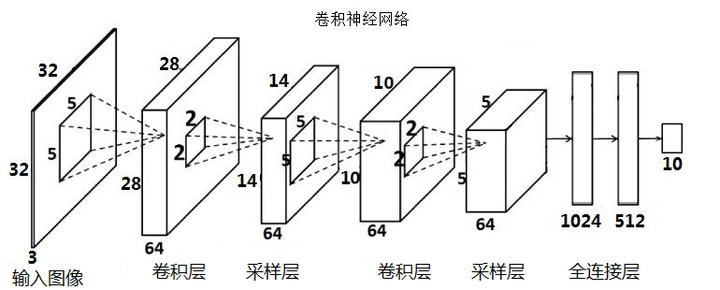

**问题：如何能够令cnn接收不同尺寸的输入与输出？**

问题的关键就在于令卷积层能够对不同尺寸的图像，输出相同大小的feature map



即然无法改变参数，就只能改变非参数的层，即池化层。

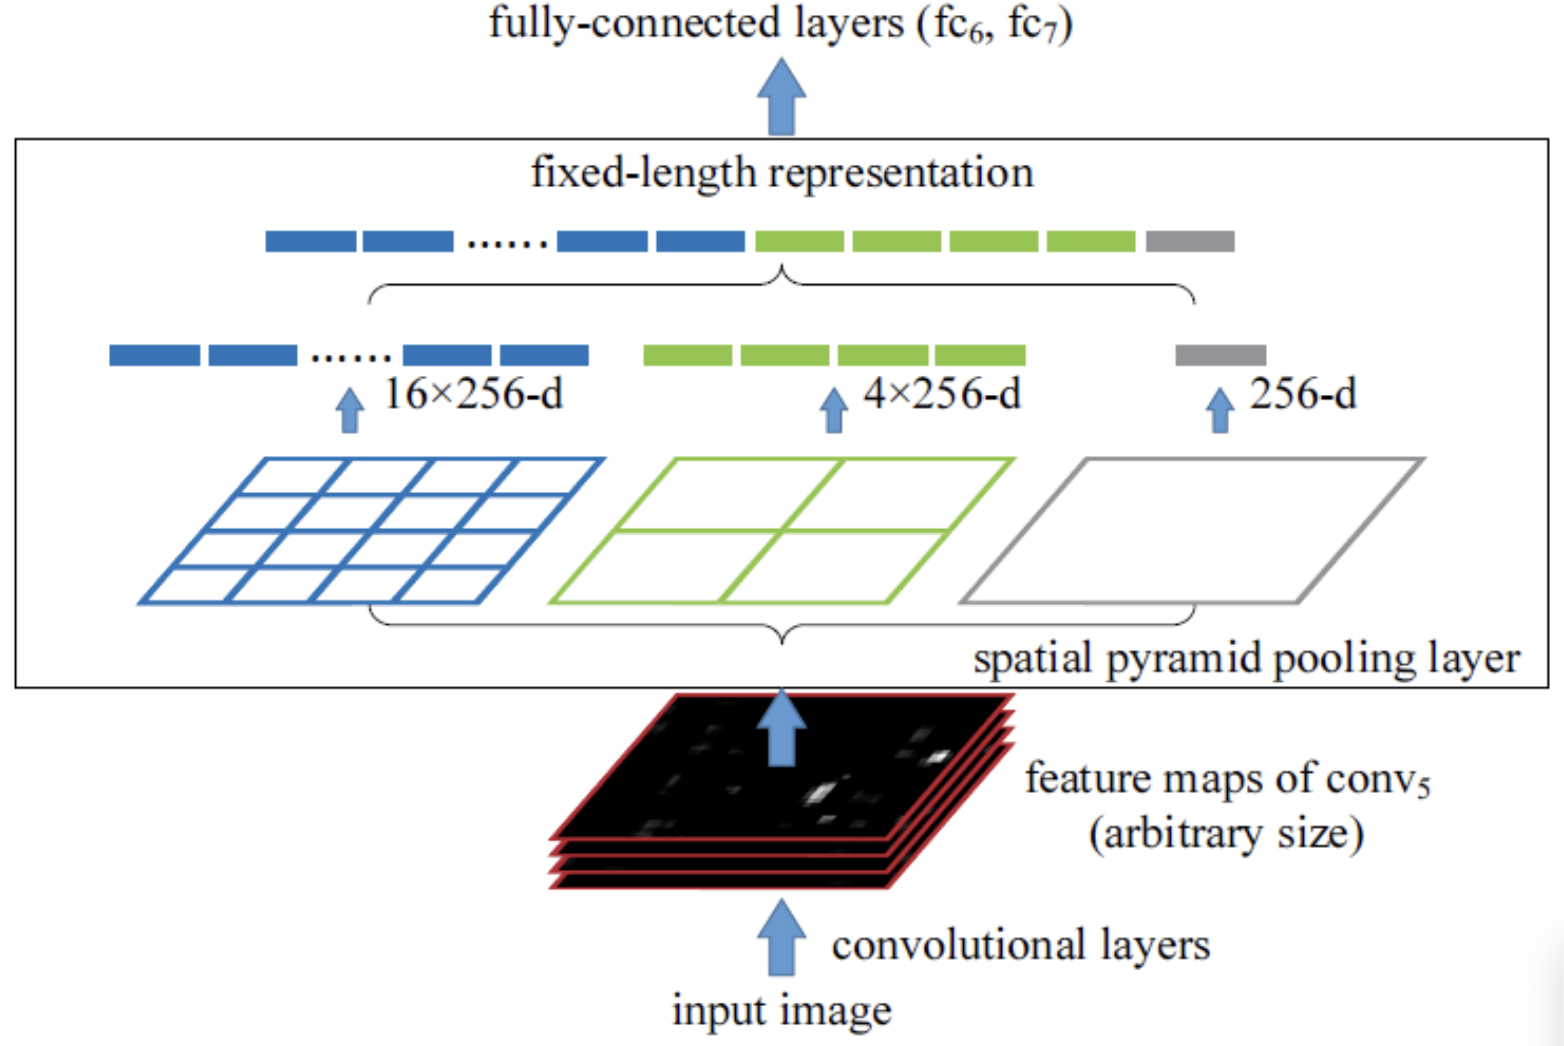

## SPP Net

### 金字塔池化层

**自适应窗口的池化层**

根据输入的feature map大小，将feature map划分为固定数量的块。

每块采用最大池化，将不同尺寸的feature map池化为固定尺寸的池化。

**金字塔池化**

分别用不同的尺度进行池化，最终得到不同尺寸的feature map池化结果。

将不同尺寸的feature拉平后 concate起来，得到最终的结果。

**具体参数**

1. 输入任意大小的，N1通道的feature map

2. 第一尺度的池化，将feature map池化为4\*4

3. 第二尺度的池化，将feature map池化为2\*2

4. 第三尺度的池化，将feature map池化为1\*1

上述特征按通道flatten，分别得到16\*N1, 4\*N1, 1\*N1的特征，连接起来，就可以得到一个21\*N1的feature map

### 统一提取特征

通过selective search得到的目标框，坐标可以映射到feature map中。

这些feature map经过空间金字塔池化的处理，得到相同大小的faeture map

这些feature map会被进一步的送入fc层进行特征提取，最终得到目标框的特征

### SPP net的总体流程

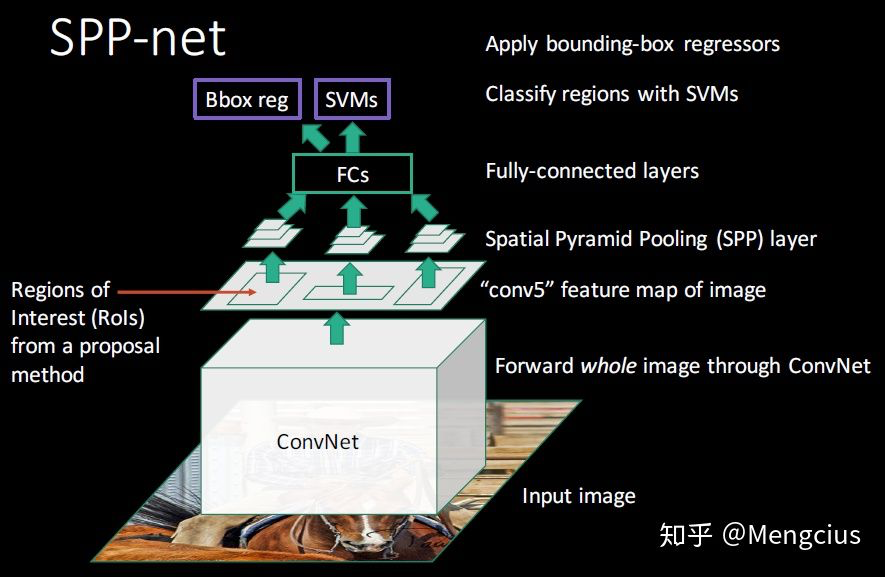

1. selective search找到若干候选框

2. 整张图像进入cnn提取特征

3. 根据候选框从feature map中提取对应的特征，送入SPP层

4. SPP层的内容经过FC提取，得到特征，最终存入硬盘

5. 硬盘中读取特征，进入SVM进行预测和训练；

6. 硬盘中读取特征，进入回归中进行预测和训练。

**训练过程**

1. 先训练ConvNet，在imagenet的基础上fine tuning(用提取到的特征微调fc)
2. 完成了conv的训练后，将提取到的特征用于svm训练
3. 训练回归(L2损失)

### SPPNET的实验结果

1. 精度略低于RCNN(降低了不到3个点)：原因：训练的时候不能微调conv(效率低下)
2. 速度远快于RCNN(38倍预测速度，3.4倍训练速度) 原因：大图像进行了一次conv，rcnn需要运行2000次

## SPPNET存在什么问题？

SPPnet较好的解决了不同尺度的图像送入cnn的问题，但是在svm和回归的分类器，使得模型的训练非常的繁琐。

具体上，我们要先把图像提取的fc特征存储到硬盘上。

然后从硬盘读取出来，再进行分类和回归。

时间慢、占用磁盘高。

## Fast RCNN--现代目标检测的雏形

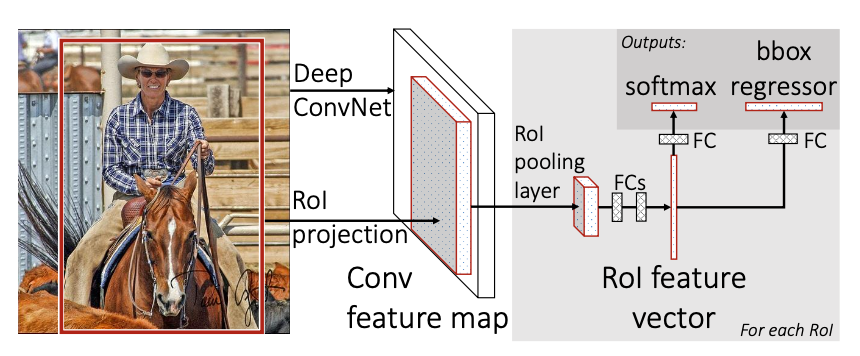

fast rcnn提出了rcnn的三个不足：

* 测试效率低

* 多阶段训练模型

* 训练计算量大

对此，fast rcnn做了以下三点改进：

1. roi pooling(spp 的一种特例)

2. 先对全图进行特征提取，然后从feature map中提取出对应区域（spp已经解决）

3. 将分类和回归合并到了一起

### fast rcnn如何训练？

对于一个分类cnn网络，需要做三件事情：

1. 将最后一层pool换成roi pooling

2. 将模型的fc分别输送给并行的两个内容：softmax分类和回归

3. 将模型的输入改变为两个：图像和proposal region

这样就把一个imagenet训练的模型载入了fast rcnn中。

之后，用voc数据集对参数进行训练。

不同于sppnet，fast rcnn这里是使用了分层的思想进行训练。

sppnet是从一个batch中均匀的采样出若干个roi框，也就是说他的batch size中必须有足够多的图像才能进行

然而，fastrcnn中，是从一张图像中提取出若干个框来训练。

这样，sppnet中会占用更多的显存。

### fast rcnn的损失函数

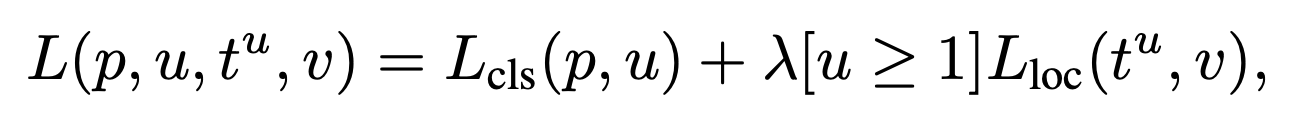

* 第一项是：分类损失，u为ground truth，p是预测结果  $-\log p_u$
* 第二项是：回归损失，采用了smooth L1损失进行

关于smooth l1损失，是为了解决l2损失的不足。

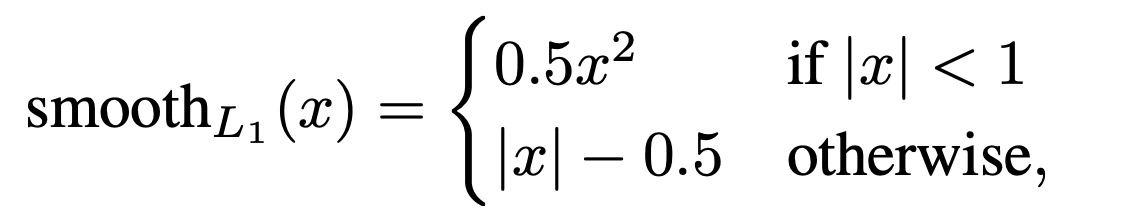

### SVD优化算法

fc层的快速优化算法：通过svd奇异值分解。

已知fc层参数W可分解为
$$W=U\Sigma V^\top$$

根据奇异值性质，舍弃其中的若干个特征值，结果近似于W

然后，左右分别乘以输入特征X如下

$$WX = U(\Sigma V^\top X)$$

分别记$\Sigma V^\top = W_1$, $U = W_2$

就可以分解成两个不同的全联接层。